<a href="https://colab.research.google.com/github/Nastarii/PCB-defect-detection/blob/main/r_cnn_pcb_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
from torch.utils.data import Subset, Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms, utils
from joblib import dump, load
from sklearn.svm import SVC
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import cv2 as cv
import zipfile
import torch

# Get Data

## Download from Github

In [ ]:
!wget --no-check-certificate \
    "https://github.com/tangsanli5201/DeepPCB/archive/refs/heads/master.zip" \
    -O "/content/DeepPCB.zip"

--2022-03-03 00:41:27--  https://github.com/tangsanli5201/DeepPCB/archive/refs/heads/master.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/tangsanli5201/DeepPCB/zip/refs/heads/master [following]
--2022-03-03 00:41:27--  https://codeload.github.com/tangsanli5201/DeepPCB/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/DeepPCB.zip’

/content/DeepPCB.zi     [         <=>        ]  86.79M  17.4MB/s    in 5.0s    

2022-03-03 00:41:32 (17.4 MB/s) - ‘/content/DeepPCB.zip’ saved [91004517]



## Extract from zip

In [ ]:
zip_format = zipfile.ZipFile('/content/DeepPCB.zip','r')
zip_format.extractall('/tmp')
zip_format.close()

## Read data with pandas

In [ ]:
dir = '/tmp/DeepPCB-master/PCBData/'

train_paths = dir + pd.read_csv(dir + 'trainval.txt', sep= " ",header= None)
test_paths = dir + pd.read_csv(dir + 'test.txt', sep= " ", header= None)

In [ ]:
def intersection_of_union(bbA, bbB):
        x1, x2 = max(bbA[0], bbB[0]), min(bbA[2], bbB[2])
        y1, y2 = max(bbA[1], bbB[1]), min(bbA[3], bbB[3])

        if x2 < x1 or y2 < y1:
            return 0.0

        inter_area = (x2 - x1) * (y2 - y1)

        bbA_area = (bbA[2] - bbA[0]) * (bbA[3] - bbA[1])
        bbB_area = (bbB[2] - bbB[0]) * (bbB[3] - bbB[1])

        iou = inter_area / float(bbA_area + bbB_area - inter_area)

        return iou

In [ ]:
img_file = train_paths.iloc[0][0]
ann_file = train_paths.iloc[0][1]

img = cv.imread(img_file.replace('.','_test.'))
ann = pd.read_csv(ann_file, sep= ' ',header=None)

In [ ]:
a = ann.iloc[0][:4]
bbox = []
for i in a:
    bbox.append(i)
prev = [390,407,425,440]

In [ ]:
iou = round(intersection_of_union(prev,bbox),2)
iou

0.15

In [ ]:
font = cv.FONT_HERSHEY_SIMPLEX

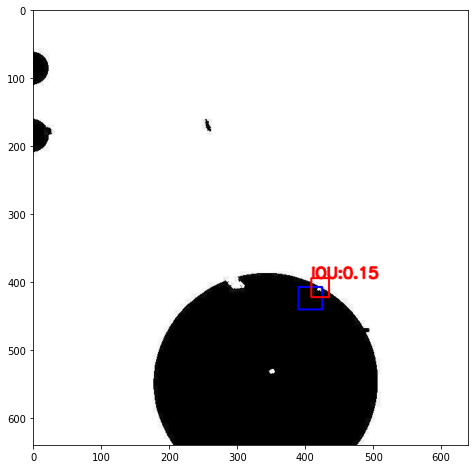

In [ ]:
cv.rectangle(img,(prev[0],prev[1]),(prev[2],prev[3]),(0,0,255),2)
cv.rectangle(img,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(255,0,0),2)
cv.putText(img,'IOU:' + str(iou),(bbox[0],bbox[1]),font, 0.75,(255,0,0),2,cv.LINE_AA)
plt.figure(figsize=(12,8))
plt.imshow(img)

# Preprocessing Data

In [ ]:
class pcb_dataset(Dataset):

    # Construtor do banco de dados - Executa ao chamar a classe
    def __init__(self, root, svm_model= None, svm_val_size=.2, output_size=32):
        self.root = root
        self.svm_model = svm_model
        self.svm_val_size = svm_val_size
        self.w, self.h = (output_size, output_size)
    
    # Preenche listas com 2 ou mais valores
    def fill(self, data, *args):
        for idx, arg in enumerate(args):
            data[idx].append(arg)

    # Prepara a imagem para o modelo de rede neural
    def nn_preprocessing(self, image):
        image = Image.fromarray(image).convert('RGB')
        return np.array(image.resize((self.w,self.h), Image.ANTIALIAS)).astype('float32')/255

    # Prepara a imagem para um modelo de support vector machine
    def svm_preprocessing(self, image):
        image = Image.fromarray(image).convert('L')
        image = image.resize((self.w,self.h), Image.ANTIALIAS)
        return np.array(image).flatten().astype('float32')/255

    # Função principal do pre processamento do banco de dados
    def main(self, extract_feature= None, train_svm= None, predict_svm=None):
        svm_input, nn_input = [], [[] for _ in range(2)]
        for idx, img_path, txt_path in self.root[[0,1]].itertuples():
            def_img = cv.imread(img_path.replace('.','_test.'))
            nor_img = cv.imread(img_path.replace('.','_temp.'))
            anns    = np.array(pd.read_csv(txt_path, sep=" ", header=None))
            
            if extract_feature:
                backg_gft = self.sift(nor_img, idx)
                foreg_gft = self.sift(def_img, idx, anns)
                svm_input.append(np.hstack((backg_gft,foreg_gft)))
            
            else:
                nn_gft = self.sift(nor_img, idx, num=2)
                for i in range(len(nn_gft[0])):
                    image = self.nn_preprocessing(nn_gft[0,i])
                    self.fill(nn_input, image, nn_gft[1,i])

                for ann in anns:
                    image = self.nn_preprocessing(def_img[ann[1]:ann[3], ann[0]:ann[2]])
                    self.fill(nn_input, image, ann[4])
        
        if predict_svm:
            svm_input = np.hstack(svm_input)    
            return self.SVM(svm_input, predict=predict_svm)

        if train_svm:
            svm_input = np.hstack(svm_input)
            self.svm_model = self.SVM(svm_input) # Classify fore and background
            return self.svm_model

        return nn_input

    def sift(self, image, index, ann= None, num= 400):
        features = [[] for _ in range(4)]
        sift = cv.SIFT_create(num)
        kps, des = sift.detectAndCompute(image,None)
        boxes = []

        for kp in kps:
            x,y = kp.pt
            size = kp.size
            sift_box = self.generate_box(x, y, 640)
            feature = image[sift_box[1]: sift_box[3], sift_box[0]:sift_box[2]]

            if ann is not None:
                    boxes = ann[:,:4]
                    for box in boxes:
                        if self.intersection_of_union(box, sift_box) > 0.5:     
                            self.fill(features,feature,1,index,sift_box)
            else:
                if len(features[1]) < 6:   
                    self.fill(features,feature,0,index,sift_box)
        return np.array(features, dtype=object)
    
    def generate_box(self,x,y,img_size, size= 32):
        w, h = (size, size)
        
        xi, yi = x - w/2, y - h/2
        xo, yo = xi + w, yi + w
        if xi < 0:
            xi, xo = 0, w
        if yi < 0:
            yi,yo = 0, h
        if xo > img_size:
            xo, xi = img_size, img_size - w
        if yo > img_size:
            yo, yi = img_size, img_size - h

        return [xi, yi, xo, yo]

    # Método para extração dos pontos de interesse
    def good_features_to_track(self, image, index, ann= None,num= 50):
        features = [[] for _ in range(4)]
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        gft = cv.goodFeaturesToTrack(gray,num,0.01,15)
        if gft is not None:
            gft = np.int0(gft)

            for f in gft:
                x, y = f.ravel()
                
                gftbox = self.generate_box(x, y, 640)
                feature = gray[gftbox[1]:gftbox[3], gftbox[0]:gftbox[2]]
                
                if ann is not None:
                    boxes = ann[:,:4]
                    for box in boxes:
                        if self.intersection_of_union(box, gftbox) > 0.35:     
                            self.fill(features,feature,1,index,gftbox)
                else:
                    if len(features[1]) < 6:   
                        self.fill(features,feature,0,index,gftbox)
                        
                    
        return np.array(features, dtype=object)

    # Avalia se o ponto de interesse extraído está próximo do objeto desejado
    def intersection_of_union(self, bbA, bbB):
        x1, x2 = max(bbA[0], bbB[0]), min(bbA[2], bbB[2])
        y1, y2 = max(bbA[1], bbB[1]), min(bbA[3], bbB[3])

        if x2 < x1 or y2 < y1:
            return 0.0

        inter_area = (x2 - x1) * (y2 - y1)

        bbA_area = (bbA[2] - bbA[0]) * (bbA[3] - bbA[1])
        bbB_area = (bbB[2] - bbB[0]) * (bbB[3] - bbB[1])

        iou = inter_area / float(bbA_area + bbB_area - inter_area)

        return iou
    
    # Função que faz o treinamento e test do support vector machine
    def SVM(self, data,predict= None):
        images, label, image_idx, gftbox = data
        train, test = [[] for _ in range(2)], [[] for _ in range(3)]
    
        for i, image in enumerate(images,0):
            svm_input = self.svm_preprocessing(image)
            
            if predict:
                
                prediction = self.svm_model.predict([svm_input])
                
                if prediction[0] == 1:
                    nn_input = self.nn_preprocessing(image)
                    self.fill(test, nn_input, image_idx[i], gftbox[i])
            else:
                self.fill(train,svm_input,int(label[i]))

        if predict:
            return test

        else:
            xtrain, xtest, ytrain, ytest = train_test_split(train[0], train[1], test_size= self.svm_val_size)

            model = SVC(kernel='poly',degree= 5, gamma= 'auto',coef0 = 0.9, random_state=21)
            model.fit(xtrain, ytrain)

            prediction = model.predict(xtest)
            accuracy   = model.score(xtest,ytest)
            print( f"SVM object detection acurracy is {accuracy}")

            return model
        

    

In [ ]:
# Classe que processa os dados de treino
class train_data(pcb_dataset):
    def __init__(self,train_root, transform=None):
        super().__init__(train_root)
        self.transform = transform
        self.image, self.label = super().main()
    
    def __len__(self):
        return len(self.image)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = (self.image[idx], self.label[idx])
        if self.transform:
            sample = self.transform(sample)

        return sample
    
    def trainSVM(self):
        return super().main(True,True)

# Classe que processa os dados de teste
class test_data(pcb_dataset):

    def __init__(self,test_root, svm_model, transform=None):
        super().__init__(test_root, svm_model)
        self.transform = transform
        self.image, self.image_idx, self.box = super().main(True, None, True)
    
    def __len__(self):
        return len(self.image)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = (self.image[idx], self.image_idx[idx], self.box[idx])
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
# Converte para tensor (obrigatório para a rede neural)
class ToTensor(object):

    def __call__(self, sample):
        if len(sample) == 2:
            image, label = sample
            return torch.from_numpy(image.transpose(2, 0, 1)).float(), torch.from_numpy(np.array(label))
        else:
            image, image_idx, box = sample
            return torch.from_numpy(image.transpose(2, 0, 1)).float(), torch.from_numpy(np.array(image_idx)), torch.from_numpy(np.array(box))

# Neural Network Model

In [ ]:
# Arquitetura de rede neural utilizada
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train

In [ ]:
ds = train_data(train_paths, transform=transforms.Compose([ToTensor()])) #cria os dados de treino

In [ ]:
svm_model = ds.trainSVM() # Treina o modelo svm

SVM object detection acurracy is 0.8505025125628141


In [ ]:
# Separa uma parte para a validação da rede neural
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

In [ ]:
train_ds, val_ds = train_val_dataset(ds, val_split=0.2)

In [ ]:
train_dl , val_dl = DataLoader(train_ds, batch_size=32, 
                               shuffle=True, num_workers=2), \
                    DataLoader(val_ds, batch_size=32,
                               shuffle=True, num_workers=2)

In [ ]:
def train_val_nn(num_epoch):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = LeNet() 
    model = model.to(device=device) 

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr= 1e-4) 

    for epoch in range(num_epoch): 
        loss_ep = 0
        
        for batch_idx, (input, targets) in enumerate(train_dl):

            input = input.to(device=device)
            targets = targets.to(device=device)

            optimizer.zero_grad()
            scores = model(input)
            loss = criterion(scores,targets)
            loss.backward()
            optimizer.step()
            loss_ep += loss.item()
        print(f"Loss in epoch {epoch + 1} :::: {loss_ep/len(train_dl)}")

        with torch.no_grad():
            num_correct = 0
            num_samples = 0
            for batch_idx, (input,targets) in enumerate(val_dl):

                input = input.to(device=device)
                targets = targets.to(device=device)

                scores = model(input)
                _, predictions = scores.max(1)
                num_correct += (predictions == targets).sum()
                num_samples += predictions.size(0)
            print(
                f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
            )
    return model

In [ ]:
model = train_val_nn(30)

Loss in epoch 1 :::: 1.571791328019924
Got 1162 / 1774 with accuracy 65.50
Loss in epoch 2 :::: 0.6312954599658648
Got 1533 / 1774 with accuracy 86.41
Loss in epoch 3 :::: 0.39784152574233106
Got 1591 / 1774 with accuracy 89.68
Loss in epoch 4 :::: 0.32972050662915986
Got 1610 / 1774 with accuracy 90.76
Loss in epoch 5 :::: 0.29852999964947097
Got 1622 / 1774 with accuracy 91.43
Loss in epoch 6 :::: 0.2774265227956815
Got 1614 / 1774 with accuracy 90.98
Loss in epoch 7 :::: 0.2613599275381447
Got 1635 / 1774 with accuracy 92.16
Loss in epoch 8 :::: 0.2457075835046199
Got 1623 / 1774 with accuracy 91.49
Loss in epoch 9 :::: 0.23617593480928525
Got 1639 / 1774 with accuracy 92.39
Loss in epoch 10 :::: 0.22588616329337563
Got 1649 / 1774 with accuracy 92.95
Loss in epoch 11 :::: 0.2128167200061652
Got 1643 / 1774 with accuracy 92.62
Loss in epoch 12 :::: 0.20618076812106748
Got 1639 / 1774 with accuracy 92.39
Loss in epoch 13 :::: 0.19931372132588615
Got 1664 / 1774 with accuracy 93.80
Lo

# Test

In [ ]:
test_ds = test_data(test_paths, svm_model, transform=transforms.Compose([ToTensor()]))

In [ ]:
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
def test_nn():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    result = [[] for _ in range(3)]

    with torch.no_grad():
        for batch_idx, (input, image_idx, local) in enumerate(test_dl):
            input = input.to(device=device)
            scores = model(input)
            _, predictions = scores.max(1)
            if batch_idx == len(test_dl) - 1:
                for i in range(len(test_ds) % 32):
                    test_ds.fill(result,int(image_idx[i]), int(predictions[i]), list(local[i]))
            else: 
                for i in range(32):
                    test_ds.fill(result,int(image_idx[i]), int(predictions[i]), list(local[i]))
    return result

In [ ]:
nn_result = test_nn()

In [ ]:
classes   = ('background','open','short','mousebite','spur','copper','pin-hole')

In [ ]:
def show_result(image_index= 0):
    for idx, (img_path) in enumerate(iter(test_paths[0]),0):
        if idx == image_index:
            feat_idxs = [i for i,val in enumerate(nn_result[0]) if val == idx]
            image = cv.imread(img_path.replace('.','_test.'))
            plt.figure(figsize=(10,10))
            plt.imshow(image)

            for j in feat_idxs:
                pred, loc = nn_result[1][j], nn_result[2][j]
                if classes[pred] != 'background':
                    rect = patches.Rectangle((loc),50,50, edgecolor='b', facecolor='none', linewidth= 0.5)
                    plt.gca().add_patch(rect)
                    plt.text(loc[0],loc[1],classes[pred],color='b')

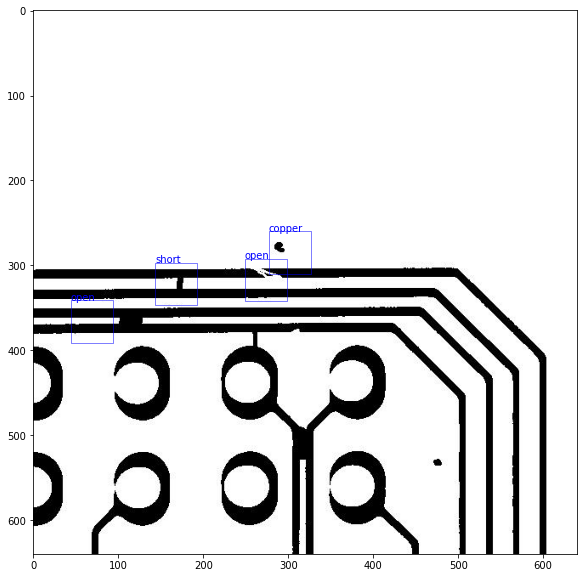

In [ ]:
show_result(8)